In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import shap
from sklearn.cluster import KMeans


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.decomposition import PCA

PATH_PROJECT = "/home/yoshraf/projects/mestrado/"

# Reading data
X_train = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/X_train.parquet")
X_test = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/X_test.parquet")
y_train = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/y_train.parquet")
y_test = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/y_test.parquet")

# Show all columns
pd.set_option('display.max_columns', None)

### Discovering

In [2]:
X_train.head()

,,,,,Idade,Total de viagens da pessoa,Hora Saída,loc_origem_count_parada,loc_origem_count_ilum_std,loc_origem_dist_metro,loc_origem_dist_trem,loc_origem_dist_term,loc_origem_dist_ciclo,loc_origem_ACC_TI_A_E_60M,loc_origem_ACC_TI_A_L_TP_,loc_destino_count_parada,loc_destino_count_ilum_std,loc_destino_dist_metro,loc_destino_dist_trem,loc_destino_dist_term,loc_destino_dist_ciclo,loc_destino_ACC_TI_A_E_60M,loc_destino_ACC_TI_A_L_TP_,per Quantidade de automóveis,per Quantidade de motocicletas,per Quantidade de bicicletas,per Renda familiar mensal,dist_od,diff_cota_od,Gênero_Masculino
Identifica pessoa,Zona de domicílio,Data da entrevista,Coordenada X domicílio,Coordenada Y domicílio,,,,,,,,,,,,,,,,,,,,,,,,,,
00282196101,28.0,23092018,331708.0,7393299.0,57.0,2.0,14.333333,1,105,1217.800987,3547.932804,3290.091381,262.058333,4271617.0,416.0,1,105,522.681713,3338.014663,1731.309643,407.683457,4428729.0,390.0,0.000000,0.000000,0.000000,695.330805,1560.489987,-24.773333,1.0
03200074102,320.0,16042018,324560.0,7387434.0,50.0,2.0,15.000000,6,98,2610.339533,1097.721910,3911.528738,870.573780,3808520.0,66.0,6,98,3145.783687,1676.729890,3548.631386,123.953564,3433596.0,50.0,0.333333,0.000000,0.000000,1259.396241,989.388700,-28.240000,0.0
01390799104,139.0,07092018,328546.0,7400276.0,22.0,3.0,18.000000,10,113,5503.727391,825.719028,3485.088204,1709.453065,4133904.0,14.0,10,113,2559.764059,635.834474,1182.175734,1144.271832,4186343.0,100.0,0.250000,0.000000,0.250000,1454.919190,4537.895988,-1.226667,1.0
01450014103,145.0,13092018,331661.0,7405242.0,3.0,3.0,16.166667,18,102,3638.680105,7013.471551,3091.080886,1541.727299,2744403.0,28.0,18,102,5278.306987,8075.650228,3071.512881,3041.387345,2046003.0,11.0,0.250000,0.250000,0.250000,1535.644803,1652.538653,-19.756667,0.0
01101363101,110.0,30082018,324281.0,7400397.0,56.0,6.0,8.500000,91,270,6241.442818,885.358367,1345.022495,1465.401416,3800721.0,20.0,91,270,7283.449171,37.424197,274.774199,1595.063710,2559290.0,18.0,0.320114,0.036663,0.192165,1020.879954,1088.601396,-2.990000,1.0


In [3]:
X_train.shape

(76598, 26)

In [4]:
X_train["Declividade"] = X_train["diff_cota_od"]/X_train["dist_od"]*100
X_test["Declividade"] = X_test["diff_cota_od"]/X_test["dist_od"]*100
X_train = X_train.drop(columns=["diff_cota_od"])
X_test = X_test.drop(columns=["diff_cota_od"])

In [5]:
y_train["Modo Principal"].value_counts(normalize=True)

A pé                                                   0.302893
Dirigindo automóvel                                    0.242278
Ônibus/micro-ônibus/perua do município de São Paulo    0.164704
Metrô                                                  0.109494
Passageiro de automóvel                                0.082587
Transporte escolar                                     0.033617
Táxi não convencional                                  0.018525
Dirigindo moto                                         0.016867
Trem                                                   0.012611
Bicicleta                                              0.008616
Táxi convencional                                      0.007807
Name: Modo Principal, dtype: float64

### Machine Learning Model

In [9]:
def rf_modeling(X_train, X_test, y_train, y_test, params):
    # Fit and Training model
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    # Predict test and train datasets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Plot Confusion Matrix
    fig, ax = plt.subplots(1, figsize=(12,6))
    plot_confusion_matrix(model, X_test, y_test, ax=ax)
    labels = ["A Pé", "Carro", "Bus", "Uber", "Bike", "Moto", "Metro/Trem"]
    # Classification Report
    print(classification_report(y_test, y_pred_test, target_names=labels))
    print("Main Features:")
    feats = {}
    for feature, importance in zip(X_train.columns, model.feature_importances_):
        feats[feature] = importance * 100
    df_imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'}).sort_values("Importance", ascending=False)
    print(df_imp.head(10))
    return model

def logit_modeling(X_train, X_test, y_train, y_test, params):
    # Fit and Training model
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    # Predict test and train datasets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Plot Confusion Matrix
    fig, ax = plt.subplots(1, figsize=(12,6))
    plot_confusion_matrix(model, X_test, y_test, ax=ax)
    labels = ["A Pé", "Carro", "Bus", "Uber", "Bike", "Moto", "Metro/Trem"]
    # Classification Report
    print(classification_report(y_test, y_pred_test, target_names=labels))
    return model

In [10]:
map_dict ={
    "Passageiro de automóvel": 1,
    "Dirigindo automóvel": 1,
    "Ônibus/micro-ônibus/perua do município de São Paulo": 2,
    "Táxi não convencional": 3,
    "Táxi convencional": 3,
    "Bicicleta": 4,
    "Dirigindo moto": 5,
    "Metrô":6,
    "Trem": 6
}

map_ref ={
        0: "A pé",
        1: "Carro",
        2: "Ônibus",
        3: "Uber",
        4: "Bike",
        5: "Moto",
        6: "Metro/trem"
    }

y_train_new = y_train["Modo Principal"].map(map_dict).fillna(0)
y_test_new = y_test["Modo Principal"].map(map_dict).fillna(0)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

        A Pé       0.79      0.89      0.84     10996
       Carro       0.59      0.81      0.68     10710
         Bus       0.55      0.41      0.47      5443
        Uber       0.00      0.00      0.00       876
        Bike       0.00      0.00      0.00       288
        Moto       0.00      0.00      0.00       553
  Metro/Trem       0.63      0.23      0.34      3963

    accuracy                           0.66     32829
   macro avg       0.36      0.34      0.33     32829
weighted avg       0.62      0.66      0.62     32829

Main Features:
                              Importance
dist_od                        49.078762
per Quantidade de automóveis   17.022885
Idade                           7.605664
per Renda familiar mensal       6.788345
Total de viagens da pessoa      3.740514
Declividade                     3.365751
loc_destino_ACC_TI_A_E_60M      1.555828
loc_destino_dist_metro          1.493621
loc_origem_ACC_TI_A

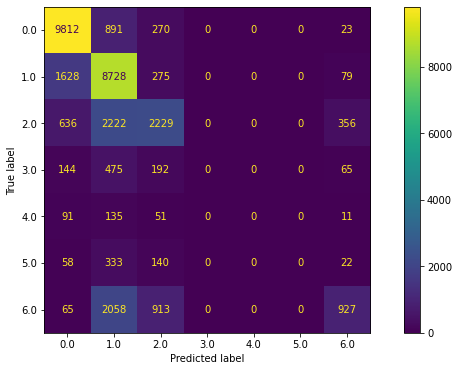

In [11]:
clf_params = {"n_estimators": 250, "max_depth": 6, "random_state": 0, "min_samples_leaf": 30, "max_features": "auto", "max_samples": .8, "n_jobs": 2}
clf_rf_simple = rf_modeling(X_train, X_test, y_train_new, y_test_new, clf_params)
# clf_rf = rf_modeling(X_train, X_test, y_train_new, y_test_new, {})

In [ ]:
clf_params = {"n_estimators": 500, "max_depth": 10, "random_state": 0, "min_samples_leaf": 30, "max_features": "auto", "max_samples": .8, "n_jobs": 2}
clf_rf = rf_modeling(X_train, X_test, y_train_new, y_test_new, clf_params)
# clf_rf = rf_modeling(X_train, X_test, y_train_new, y_test_new, {})

In [ ]:
clf_logit = logit_modeling(X_train, X_test, y_train_new, y_test_new, {"max_iter": 1000})

In [12]:
sample = X_train.sample(1000, random_state=0)
# explainer = shap.Explainer(clf_rf)
explainer_simple = shap.TreeExplainer(clf_rf_simple)
shap_values_simple = explainer_simple(sample)

In [ ]:
sample = X_train.sample(1000)
# explainer = shap.Explainer(clf_rf)
explainer = shap.TreeExplainer(clf_rf)
shap_values = explainer(sample)

# SHAP Feature Importance

In [13]:
shap_values = shap_values_simple

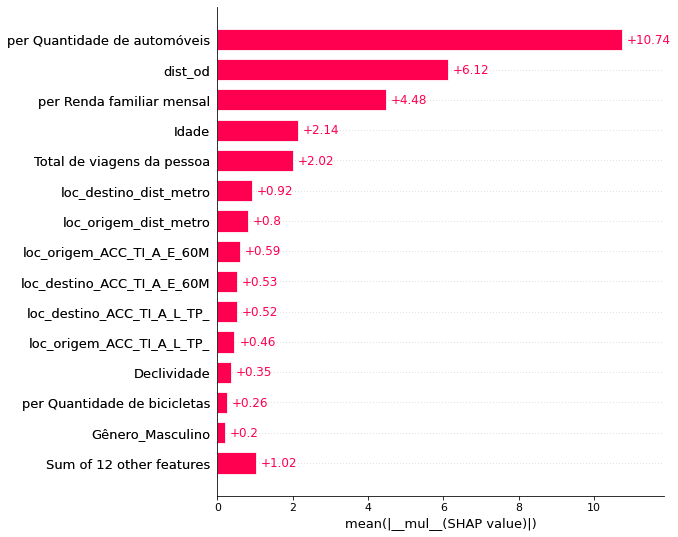

In [14]:
shap.plots.bar(shap_values[:,:,1]*100, max_display=15)

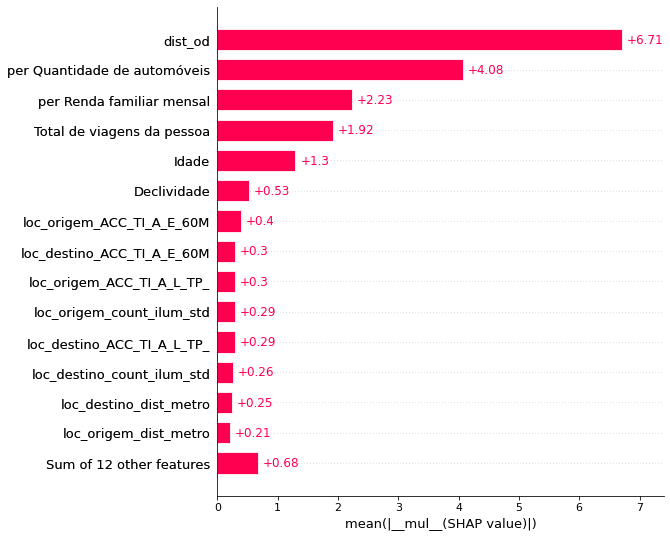

In [15]:
shap.plots.bar(shap_values[:,:,2]*100, max_display=15)

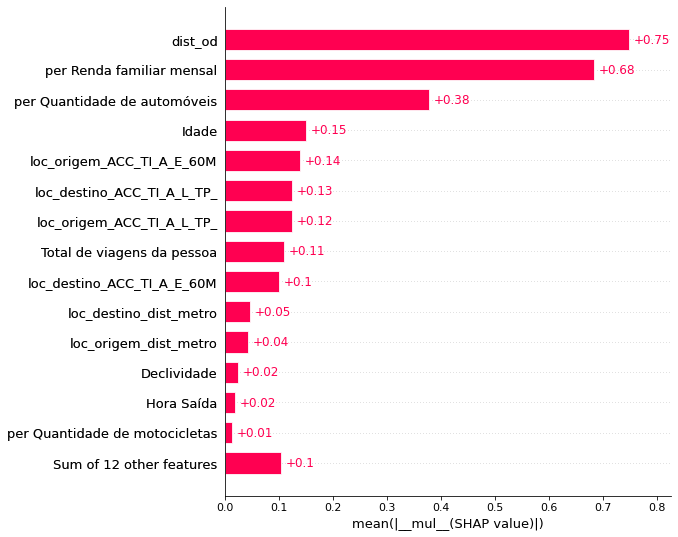

In [16]:
shap.plots.bar(shap_values[:,:,3]*100, max_display=15)

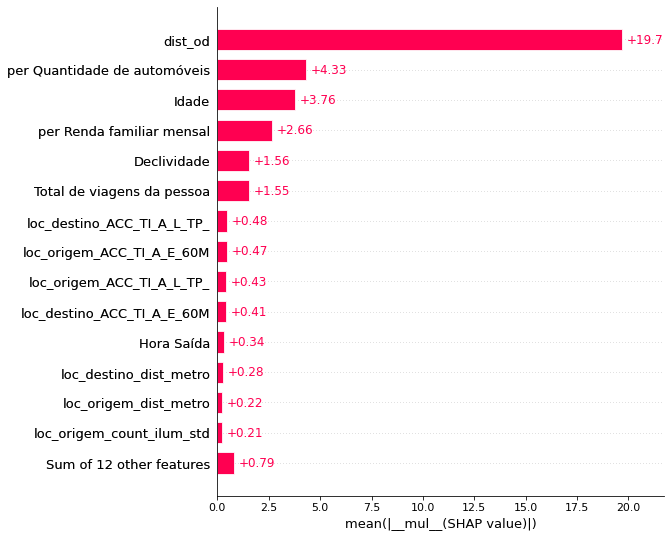

In [17]:
shap.plots.bar(shap_values[:,:,0]*100, max_display=15)

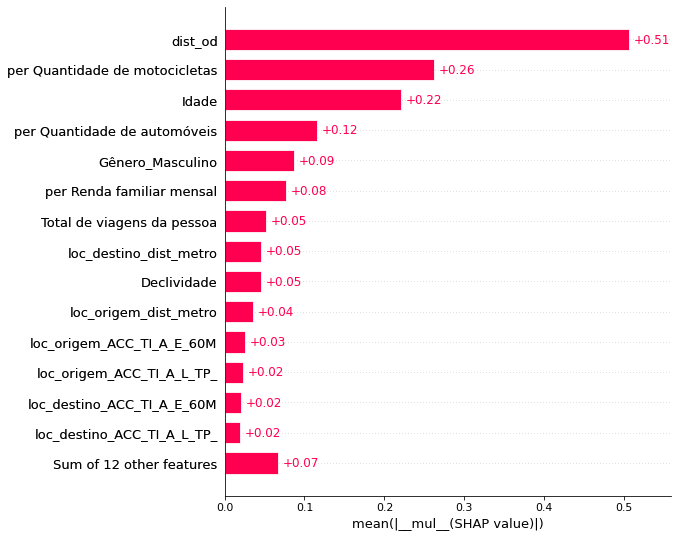

In [18]:
shap.plots.bar(shap_values[:,:,5]*100, max_display=15)

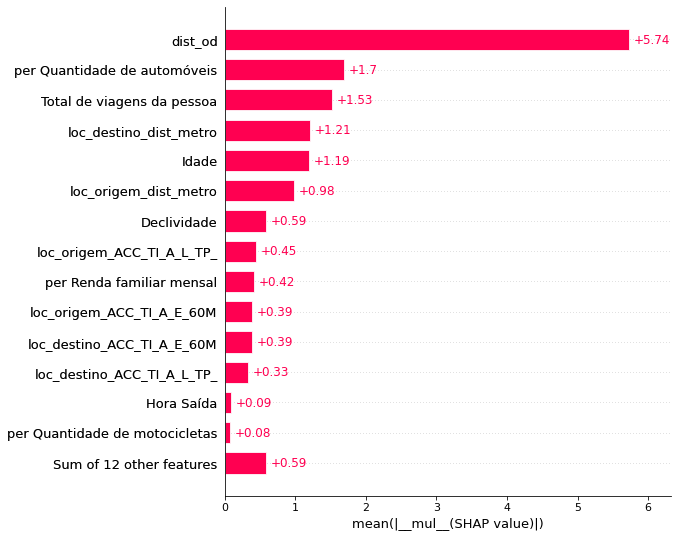

In [19]:
shap.plots.bar(shap_values[:,:,6]*100, max_display=15)

### Beeswarm Plot

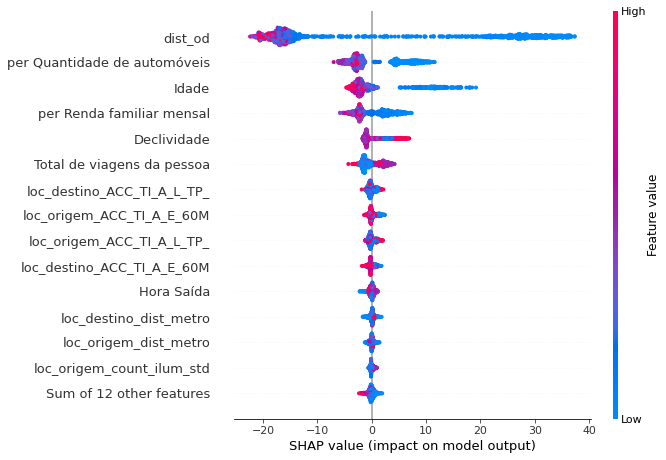

In [20]:
shap.plots.beeswarm(shap_values[:,:,0]*100, max_display=15)

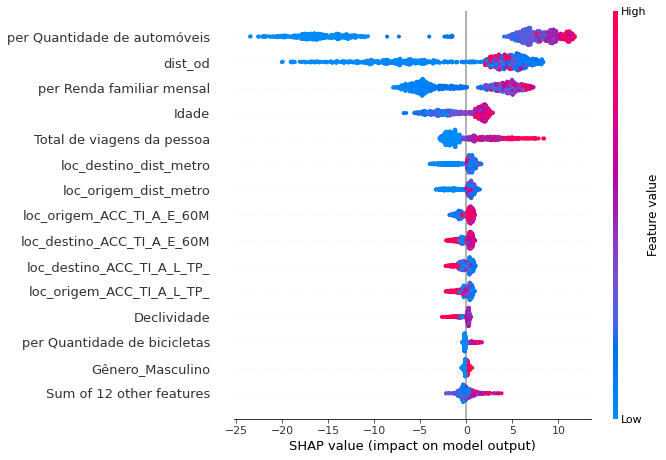

In [21]:
shap.plots.beeswarm(shap_values[:,:,1]*100, max_display=15)

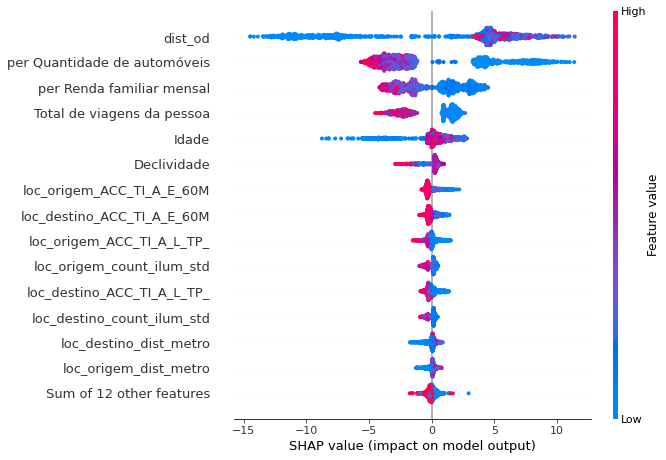

In [22]:
shap.plots.beeswarm(shap_values[:,:,2]*100, max_display=15)

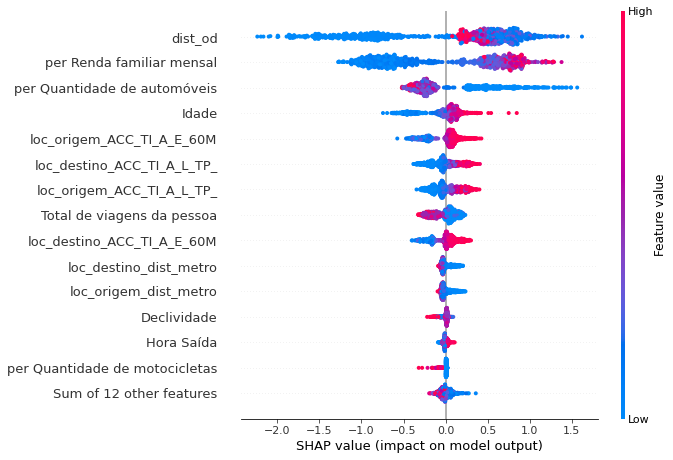

In [23]:
shap.plots.beeswarm(shap_values[:,:,3]*100, max_display=15)

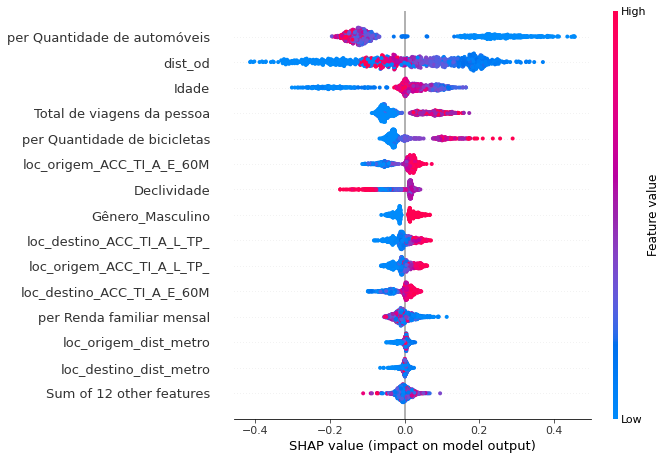

In [24]:
shap.plots.beeswarm(shap_values[:,:,4]*100, max_display=15)

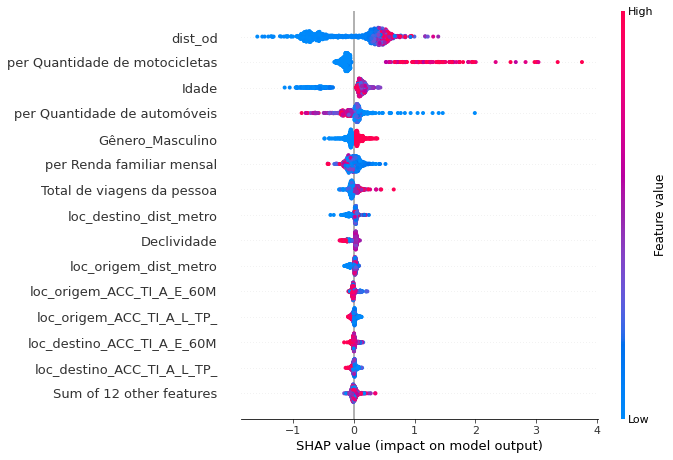

In [25]:
shap.plots.beeswarm(shap_values[:,:,5]*100, max_display=15)

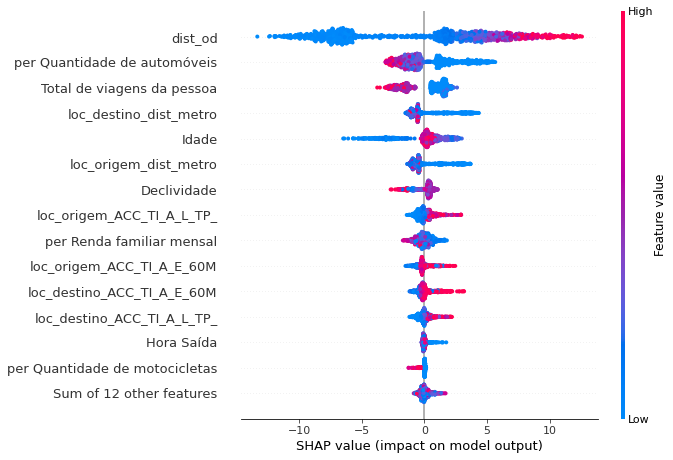

In [26]:
shap.plots.beeswarm(shap_values[:,:,6]*100, max_display=15)

### Understanding Main Features
#### SHAP PDP

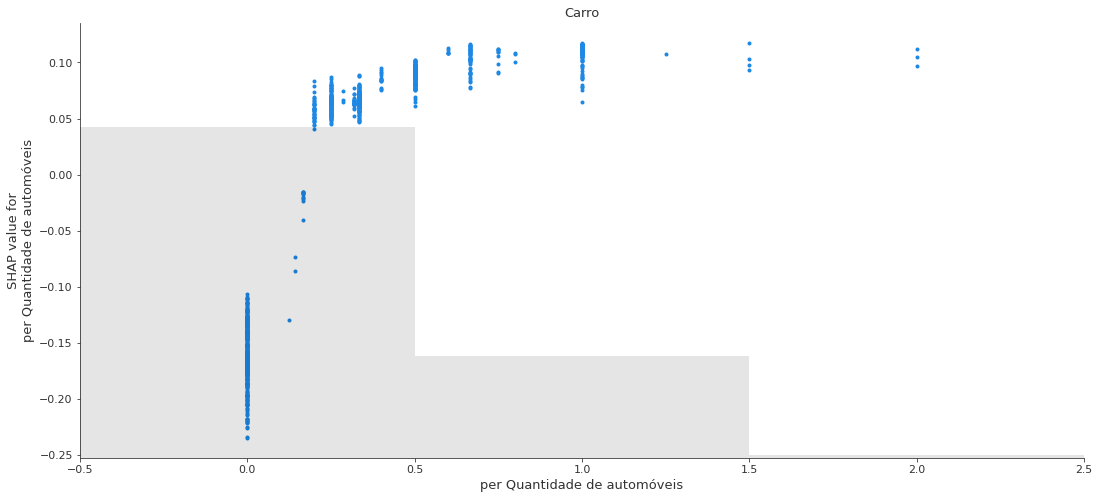

In [27]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 1
shap.plots.scatter(shap_values[:,"per Quantidade de automóveis",modo], ax=ax, title=map_ref[modo])

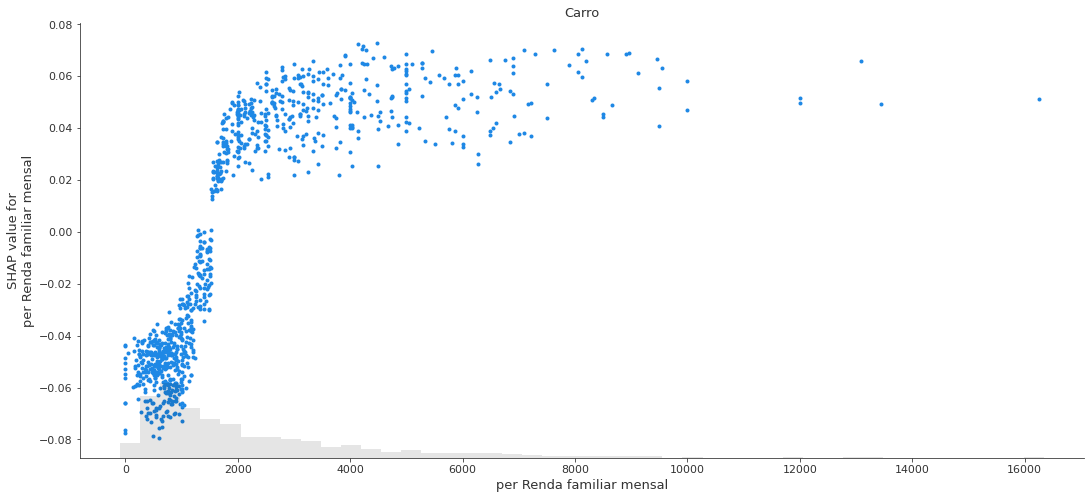

In [28]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 1
shap.plots.scatter(shap_values[:,"per Renda familiar mensal",modo], ax=ax, title=map_ref[modo])

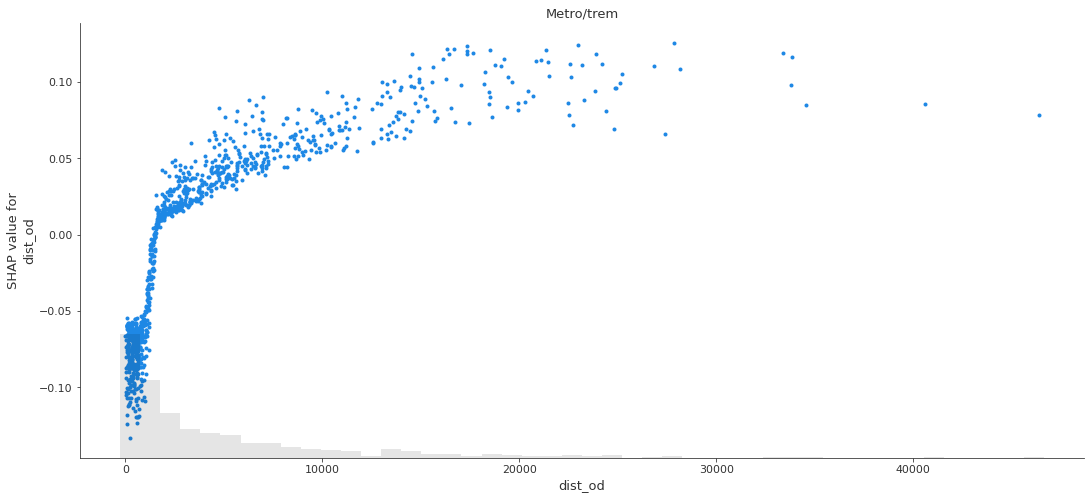

In [29]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 6
shap.plots.scatter(shap_values[:,"dist_od",modo], ax=ax, title=map_ref[modo])

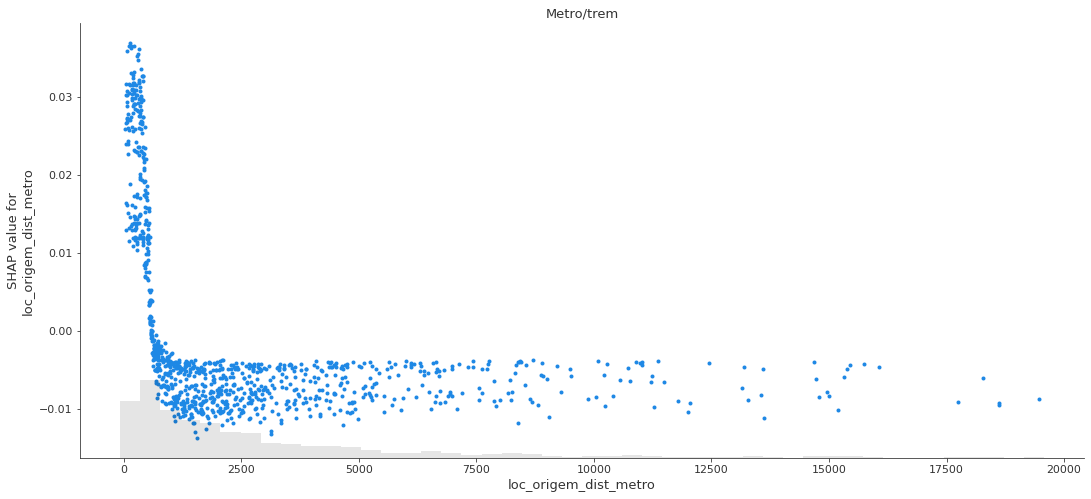

In [30]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 6
shap.plots.scatter(shap_values[:,"loc_origem_dist_metro",modo], ax=ax, title=map_ref[modo])

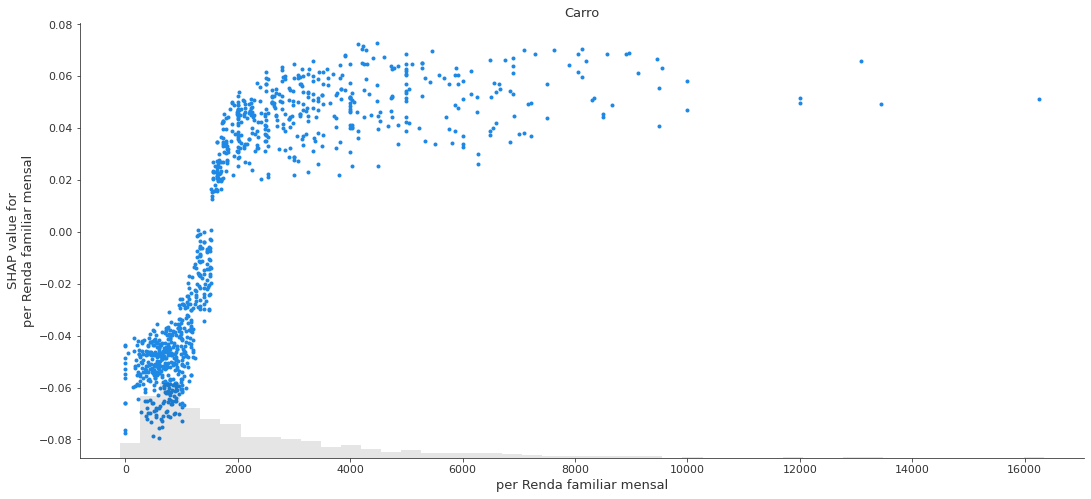

In [71]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 1
shap.plots.scatter(shap_values[:,"per Renda familiar mensal",modo], ax=ax, title=map_ref[modo])

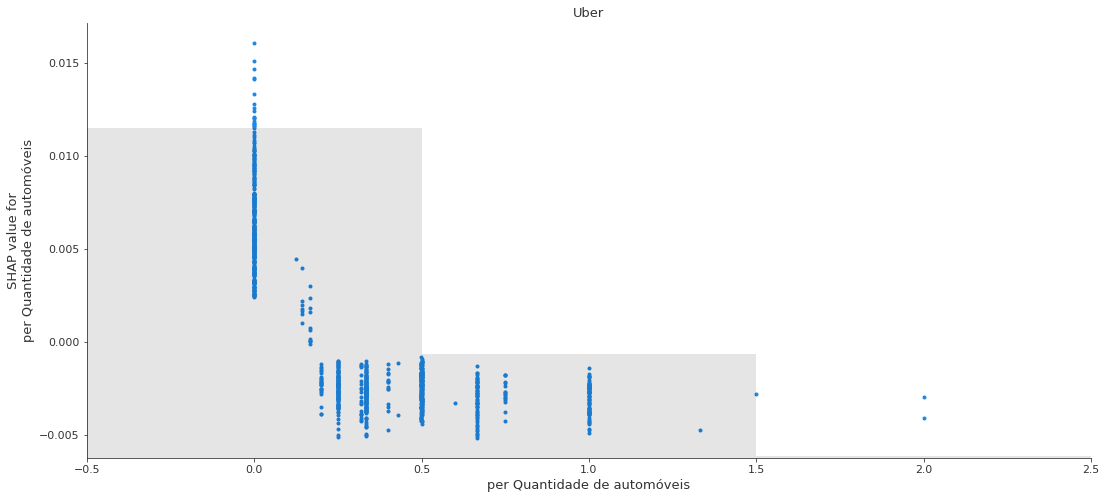

In [50]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 3
shap.plots.scatter(shap_values[:,"per Quantidade de automóveis",modo], ax=ax, title=map_ref[modo])

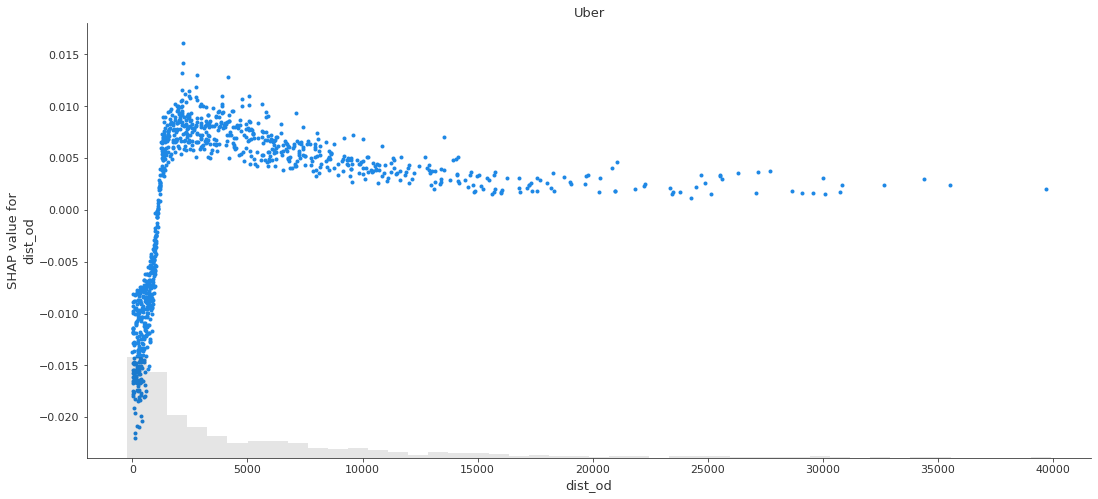

In [136]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 3
shap.plots.scatter(shap_values[:,"dist_od",modo], ax=ax,  title=map_ref[modo])

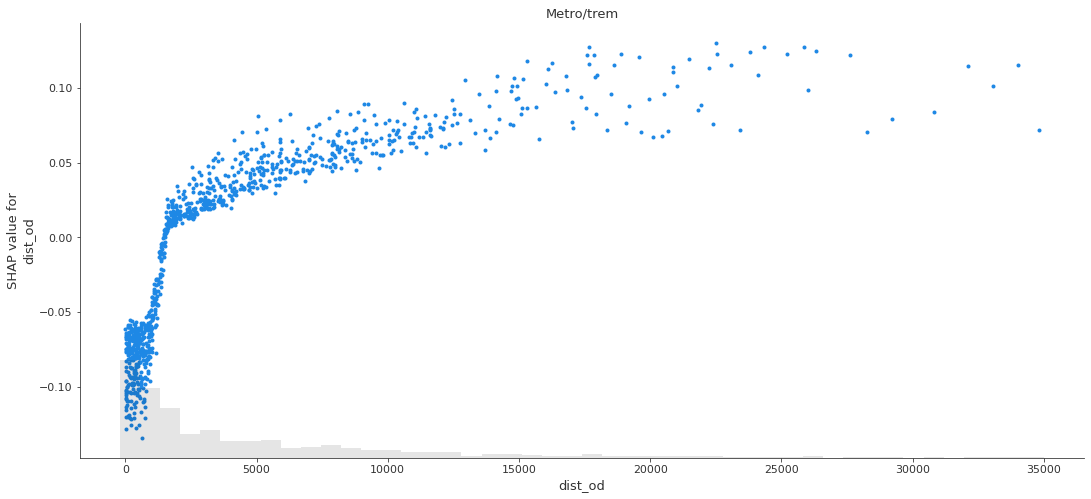

In [47]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 6
shap.plots.scatter(shap_values[:,"dist_od",modo], ax=ax,  title=map_ref[modo])

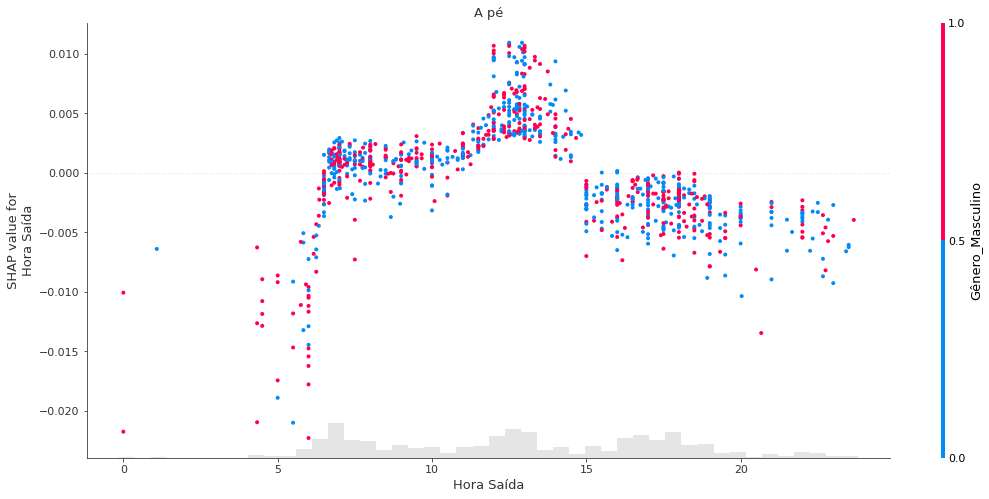

In [67]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 0
shap.plots.scatter(shap_values[:,"Hora Saída",modo], color=shap_values[:,"Gênero_Masculino",modo], ax=ax,  title=map_ref[modo])

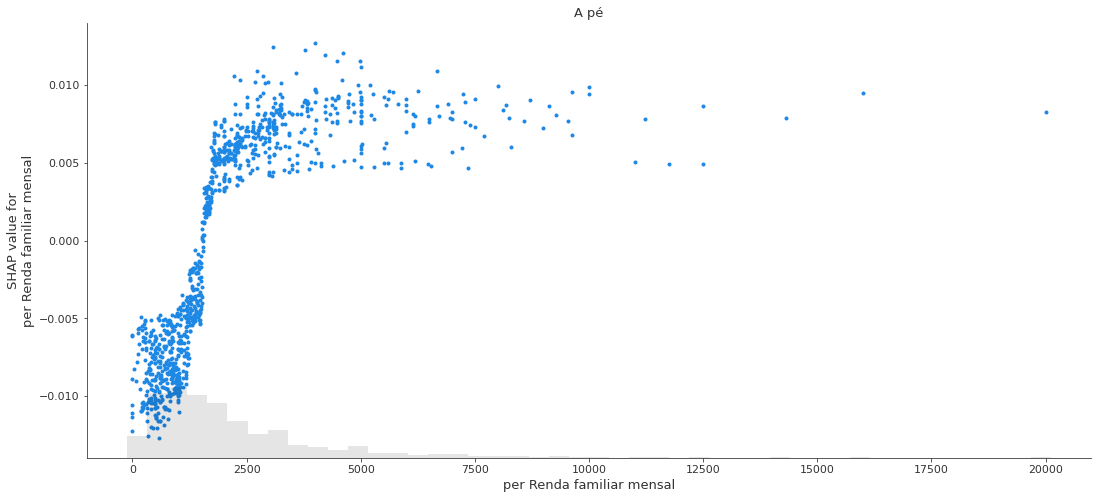

In [55]:
fig, ax = plt.subplots(1, figsize=(18,8))
shap.plots.scatter(shap_values[:,'per Renda familiar mensal',3], ax=ax,  title=map_ref[modo])

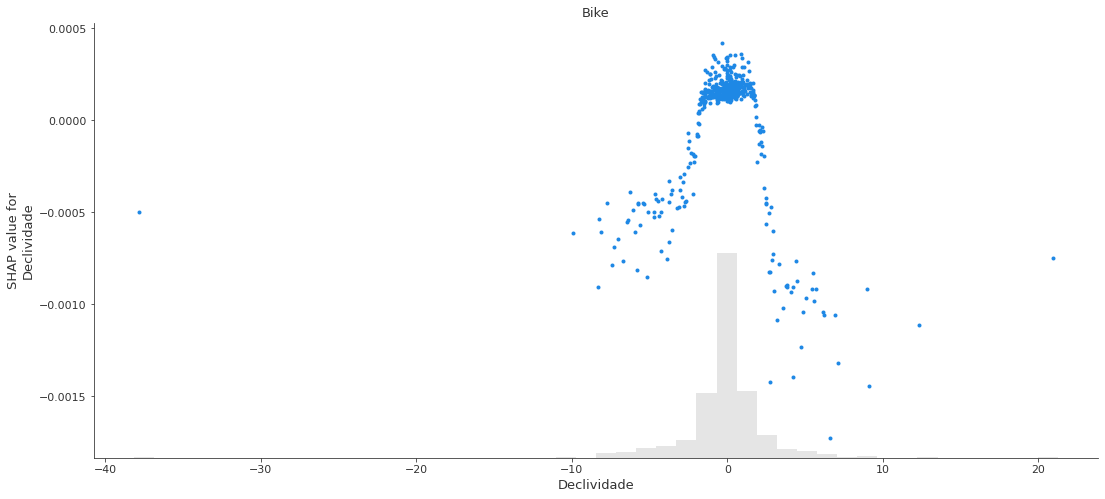

In [66]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo=4
shap.plots.scatter(shap_values.sample(500)[:,'Declividade',modo],  ax=ax,  title=map_ref[modo])

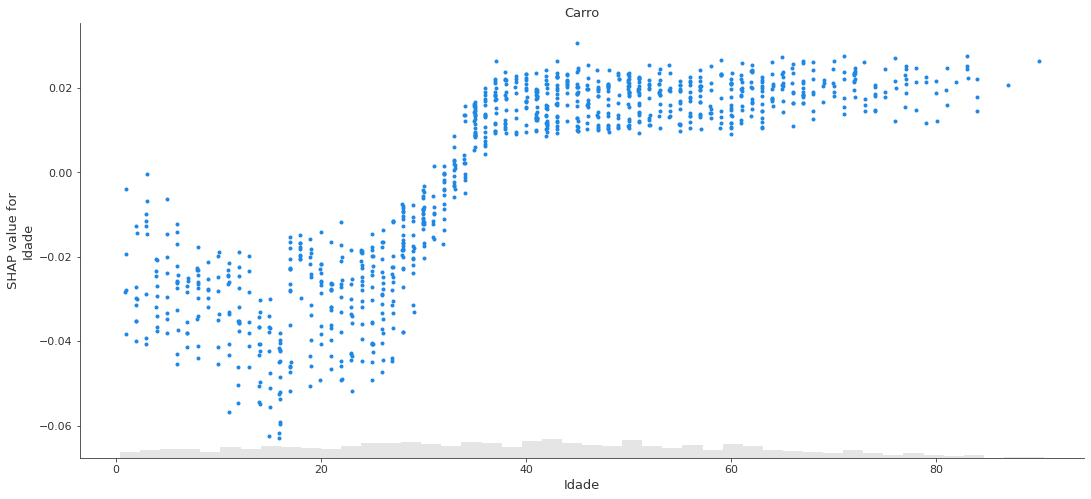

In [139]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 1
shap.plots.scatter(shap_values[:,"Idade",modo], ax=ax,  title=map_ref[modo])

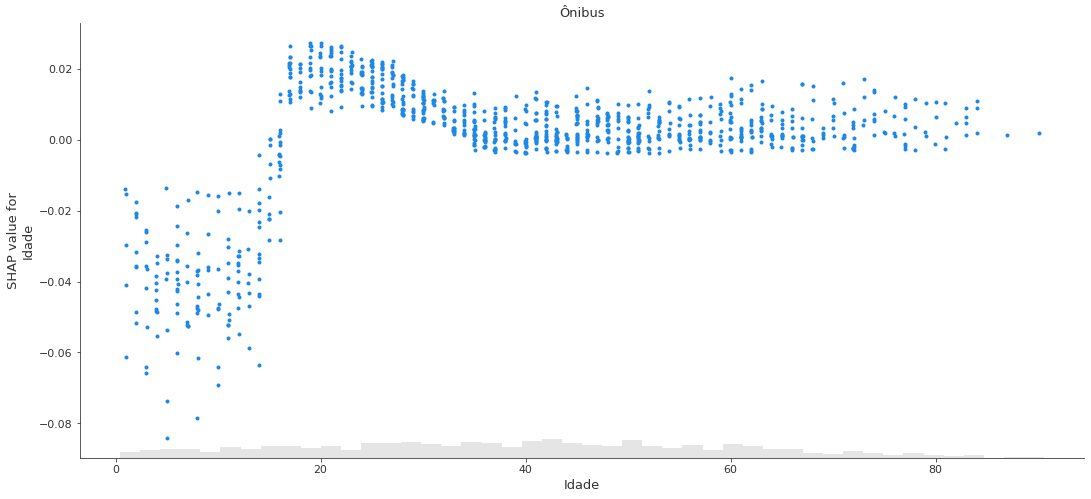

In [140]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 2
shap.plots.scatter(shap_values[:,"Idade",modo], ax=ax,  title=map_ref[modo])

#### Plot for 2 Features

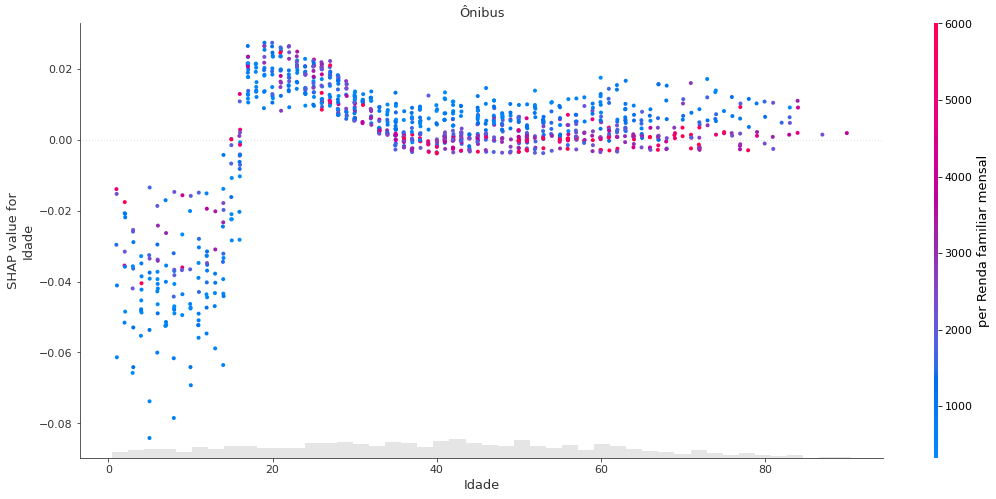

In [62]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 2
shap.plots.scatter(shap_values[:,"Idade",modo], color=shap_values[:,"per Renda familiar mensal",2], ax=ax,  title=map_ref[modo])

In [92]:
a = shap_values[:,"loc_origem_dist_metro",modo][shap_values[:,"loc_origem_dist_metro",modo].data < 2000 ]

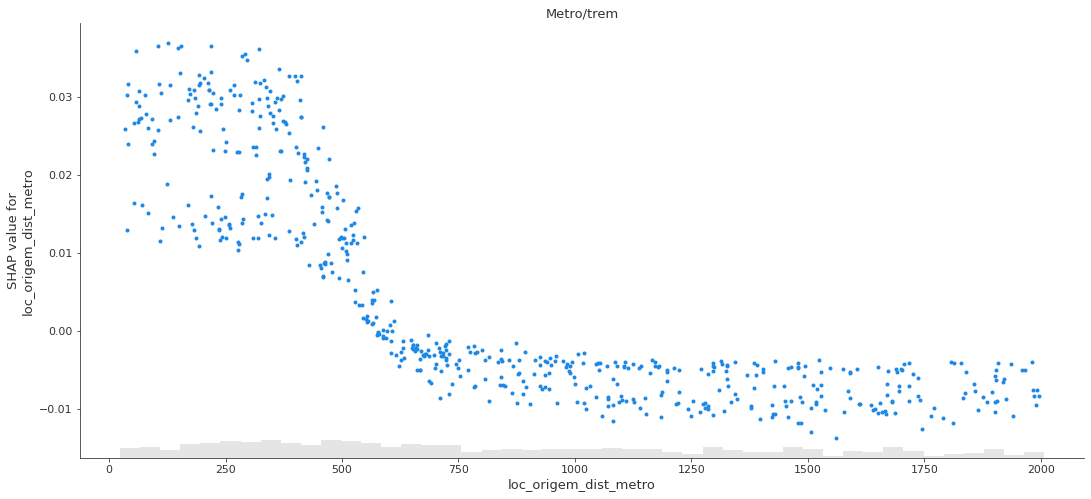

In [93]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 6
shap.plots.scatter(a, ax=ax, title=map_ref[modo])

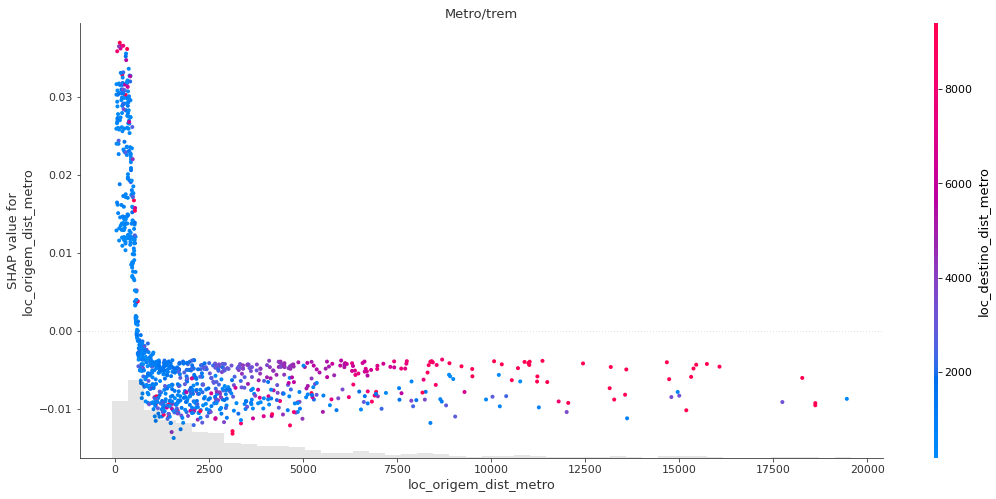

In [73]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 6
shap.plots.scatter(shap_values[:,"loc_origem_dist_metro",modo], color=shap_values[:,"loc_destino_dist_metro", modo], ax=ax, title=map_ref[modo])

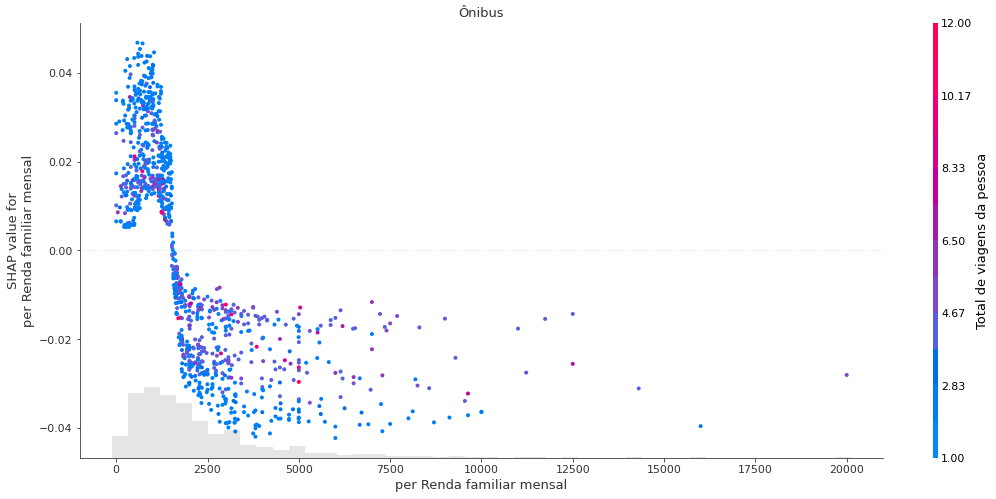

In [64]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 2
shap.plots.scatter(shap_values[:,"per Renda familiar mensal",modo], color=shap_values[:,"Total de viagens da pessoa", modo], ax=ax, title=map_ref[modo])

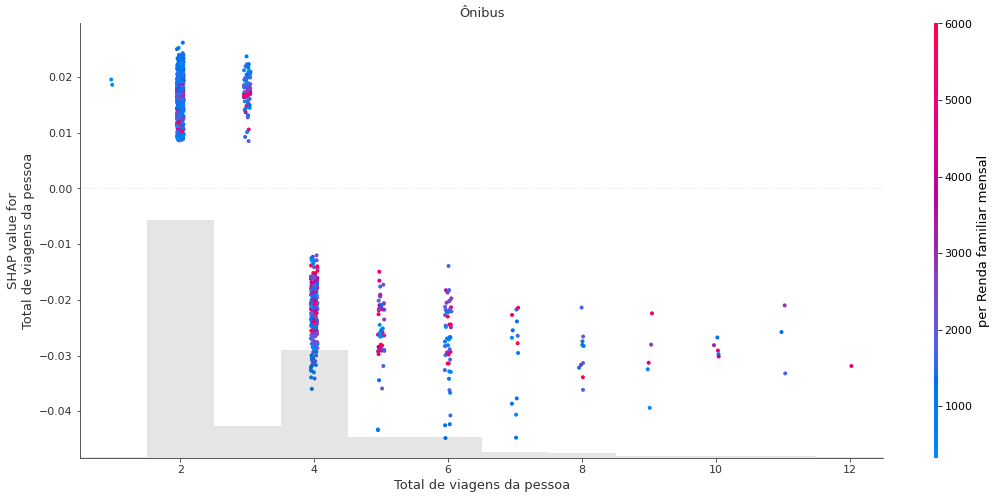

In [65]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 2
shap.plots.scatter(shap_values[:,"Total de viagens da pessoa",modo], color=shap_values[:,"per Renda familiar mensal", modo], ax=ax, title=map_ref[modo])

#### Categorical Data

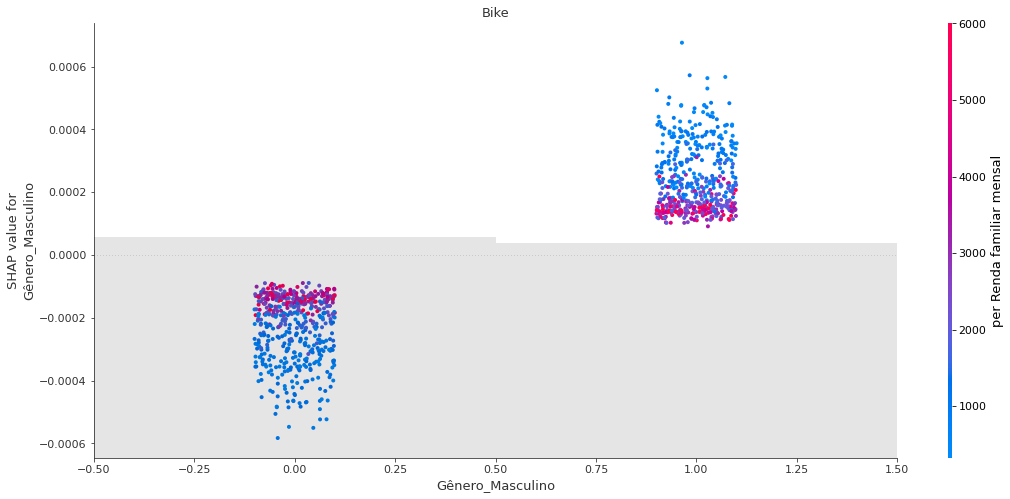

In [66]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 4
shap.plots.scatter(shap_values[:,"Gênero_Masculino",modo], color=shap_values[:,"per Renda familiar mensal",modo],  title=map_ref[modo], ax=ax)

### Correlation Matrix

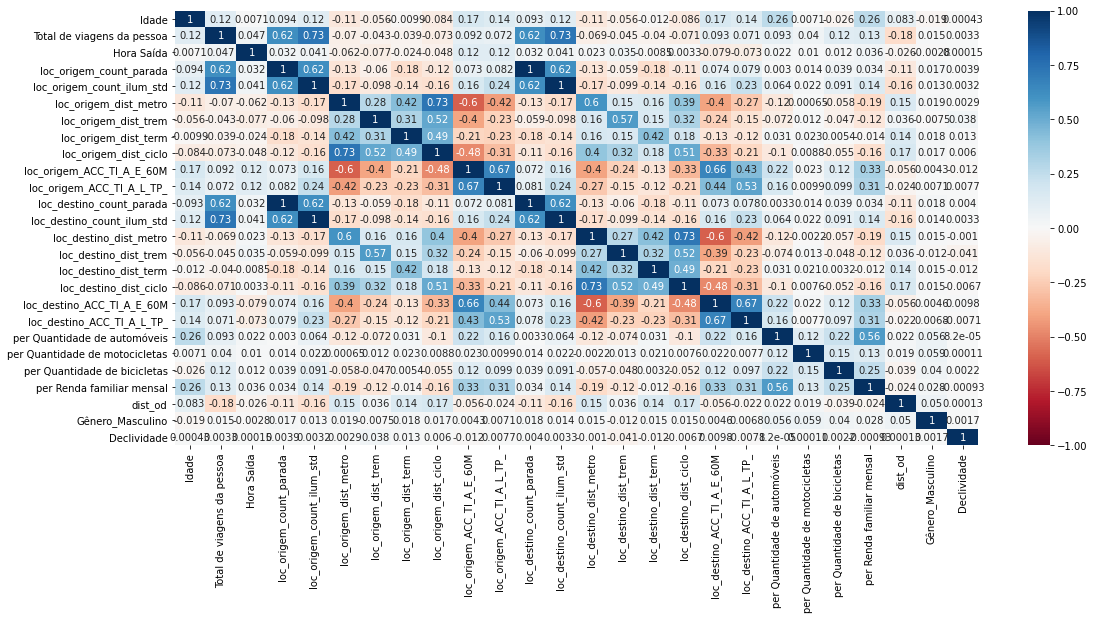

In [67]:
fig, ax = plt.subplots(1, figsize=(18,8))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu', ax=ax)

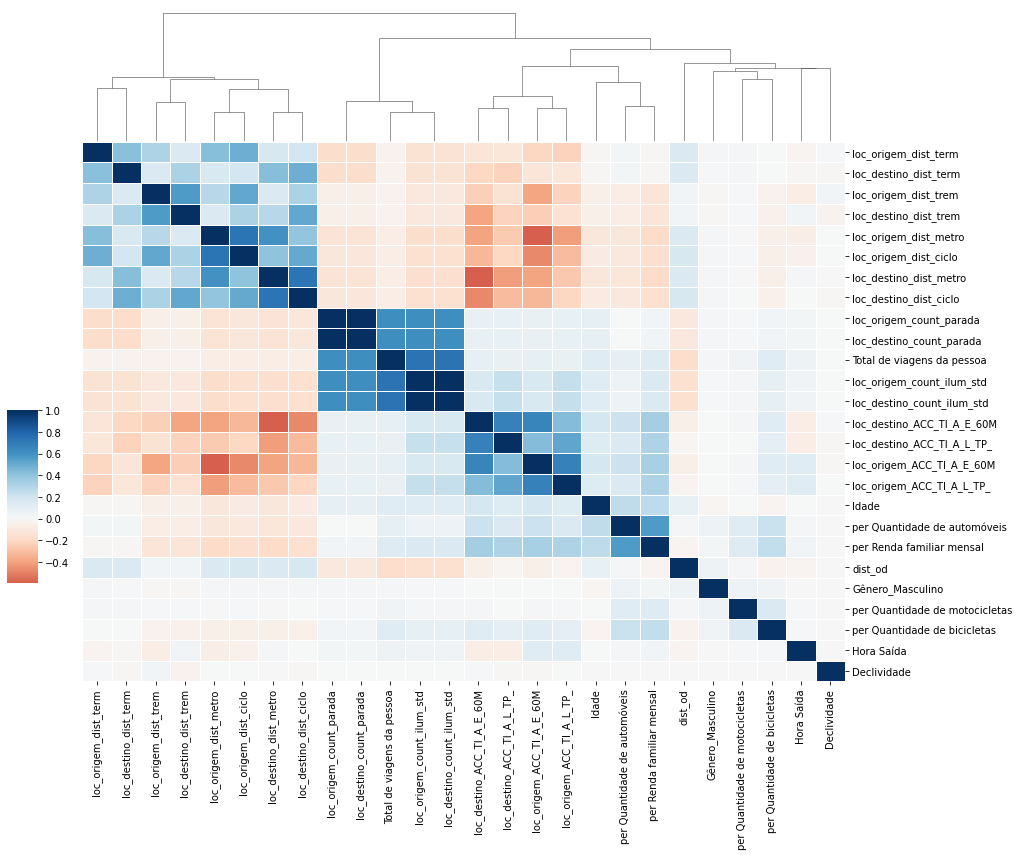

In [68]:
f = .8
g = sns.clustermap(X_train.corr(), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(18*f, 15*f))
g.ax_row_dendrogram.remove()

### SHAP Correlation Matrix | Feature Behavior Correlation

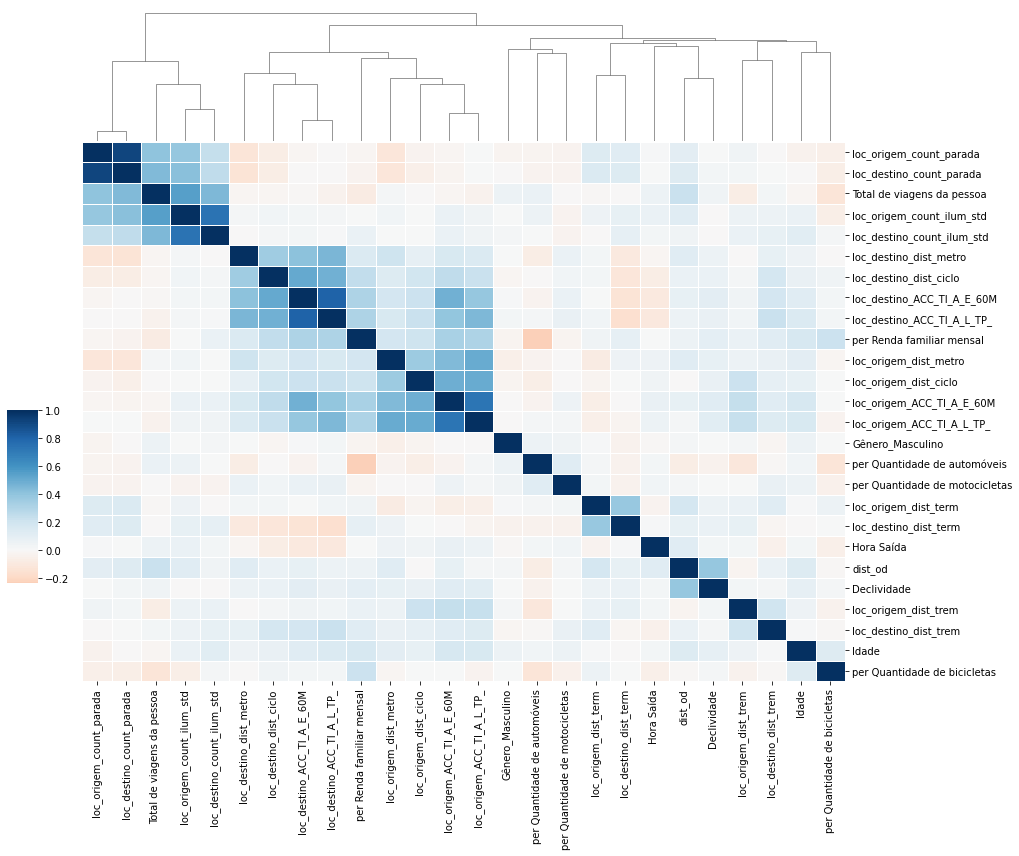

In [69]:
df_shap = pd.DataFrame(shap_values.values[:,:,3], columns=shap_values.feature_names)

f = .8
# Draw the full plot
g = sns.clustermap(df_shap.corr(), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(18*f, 15*f))
g.ax_row_dendrogram.remove()

### SHAP Clustering

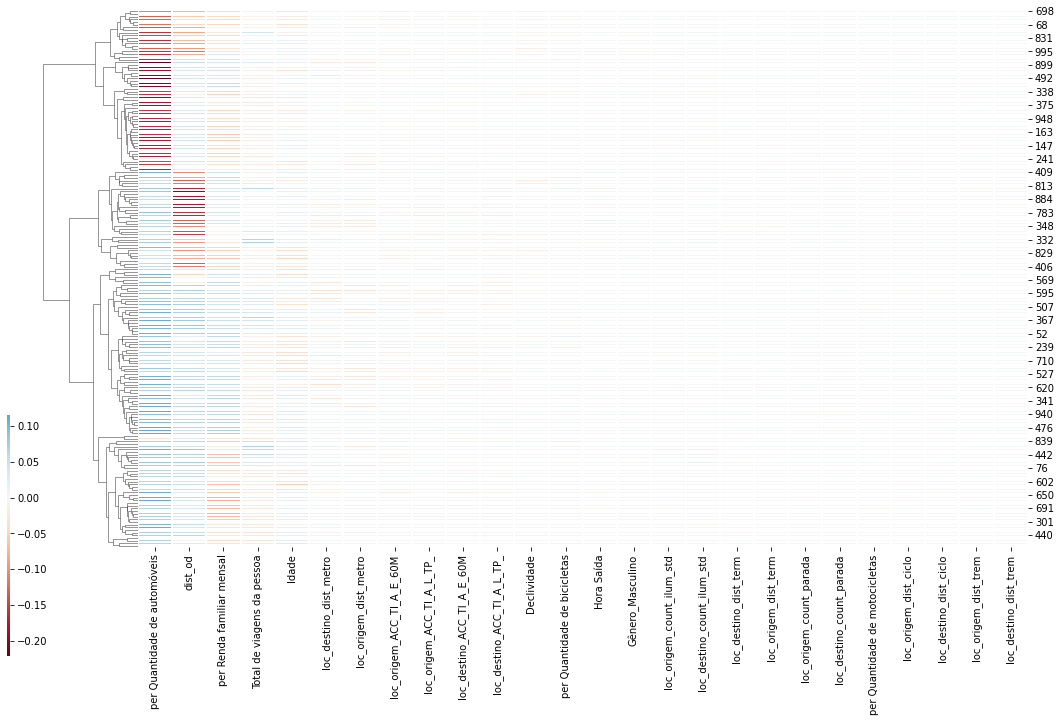

In [41]:
df_shap = pd.DataFrame(shap_values.values[:,:,1], columns=shap_values.feature_names)

f = .8
# Draw the full plot
g = sns.clustermap(df_shap.sample(200), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-0.02, 0.08, .003, 0.28),
                   linewidths=.05, figsize=(18*f, 15*f))
g.ax_col_dendrogram.remove()

In [42]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_shap.values)
pca.explained_variance_ratio_.sum()

0.8476187872412515

<AxesSubplot:>

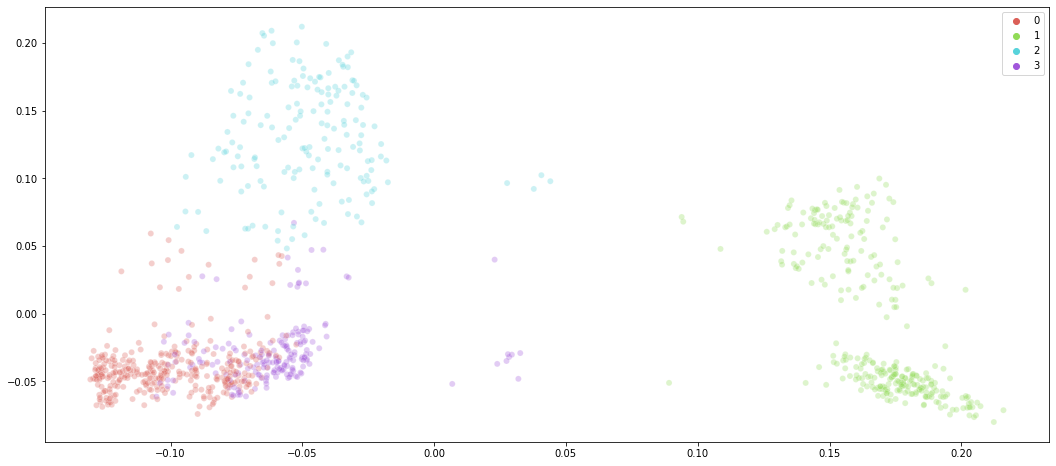

In [45]:
fig, ax = plt.subplots(1, figsize=(18,8))
n_cluster = 4
kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(df_shap)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=kmeans.labels_, alpha=.3, palette=sns.color_palette("hls",n_cluster))

### SHAP Clustering | Heatmap

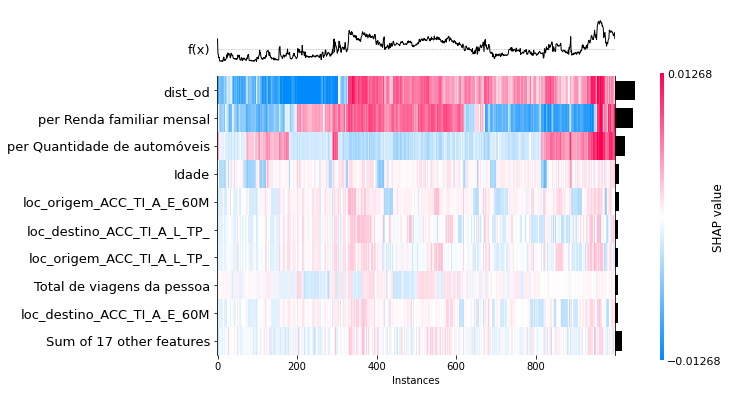

In [36]:
shap.plots.heatmap(shap_values[:,:,3])

### Demographic parity

FixedFormatter should only be used together with FixedLocator


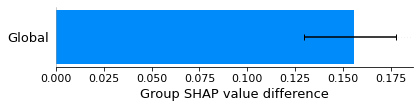

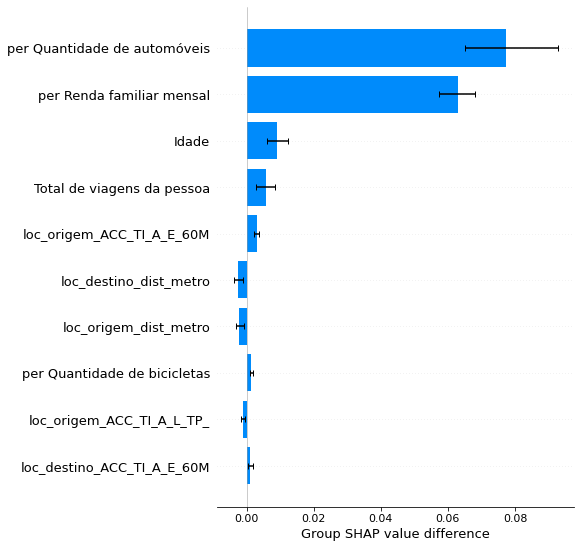

In [117]:
group_A = sample["per Renda familiar mensal"].values >= 3000
shap.group_difference_plot(shap_values[:,:,1].values.sum(1), group_A, ["Global"], max_display=10)
shap.group_difference_plot(shap_values[:,:,1].values, group_A, sample.columns, max_display=10)

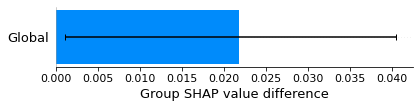

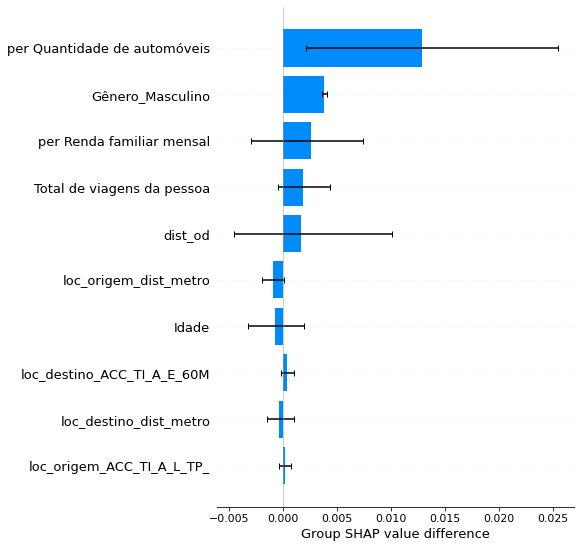

In [118]:
group_A = sample["Gênero_Masculino"].values == 1
shap.group_difference_plot(shap_values[:,:,1].values.sum(1), group_A, ["Global"], max_display=10)
shap.group_difference_plot(shap_values[:,:,1].values, group_A, sample.columns, max_display=10)

### GeoDemographic parity

In [38]:
df_geo

,NumeroDist,NomeDistri,Area_ha,geometry
0,1,Água Rasa,715.05,"POLYGON Z ((341424.968 7392693.358 0.000, 3414..."
1,2,Alto de Pinheiros,751.26,"POLYGON Z ((327280.093 7394982.866 0.000, 3272..."
2,3,Anhanguera,3339.95,"POLYGON Z ((320101.634 7408074.713 0.000, 3200..."
3,4,Aricanduva,686.26,"POLYGON Z ((346773.152 7391533.787 0.000, 3467..."
4,5,Artur Alvim,653.04,"POLYGON Z ((349640.523 7395895.759 0.000, 3496..."
...,...,...,...,...
129,130,São Caetano do Sul,1536.53,"POLYGON Z ((338516.704 7384636.788 0.000, 3385..."
130,131,São Lourenço da Serra,18674.34,"POLYGON Z ((297406.457 7366514.072 0.000, 2974..."
131,132,Suzano,20666.94,"POLYGON Z ((358890.724 7387410.623 0.000, 3588..."
132,133,Taboão da Serra,2043.37,"POLYGON Z ((314534.134 7384779.974 0.000, 3142..."


Index(['NumeroDist', 'NomeDistri', 'Area_ha', 'geometry'], dtype='object')


<AxesSubplot:>

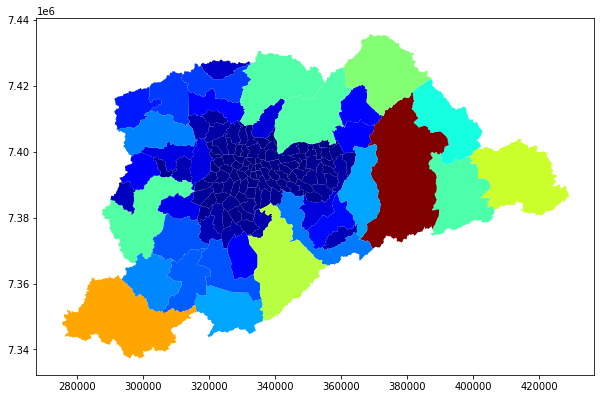

In [37]:
import geopandas as gpd
df_geo = gpd.read_file("/home/yoshraf/projects/mestrado/data/gis/od2017/Distritos_2017_region.shp")
print(df_geo.columns)
df_geo.plot(cmap="jet", column= "Area_ha", figsize=(10,10))

In [122]:
def relevancia(perif, centro, model_idx, map_ref):
    # Georeferênia
    df_sample_geo = gpd.GeoDataFrame(geometry = gpd.points_from_xy(X_train.reset_index()["Coordenada X domicílio"], X_train.reset_index()["Coordenada Y domicílio"]))
    # Seleciona os distristos de interesse
    df_geo_centro = df_geo[df_geo["NomeDistri"].isin(centro)]
    df_geo_perif = df_geo[df_geo["NomeDistri"].isin(perif)]
    # Boolianos se é centro ou periferia do 'X_train'
    bool_centro = gpd.sjoin(df_sample_geo, df_geo_centro, how="left", op='intersects')["index_right"].fillna(0) != 0
    bool_perif = gpd.sjoin(df_sample_geo, df_geo_perif, how="left", op='intersects')["index_right"].fillna(0) != 0
    # Estamos interessados apenas neste dois: Centro e Periferia
    df_final = X_train.reset_index()[bool_centro + bool_perif].set_index(sample.index.names)
    # Calculate shap values for those data
    shap_values = explainer_simple(df_final)
    # Create a GeoDataFrame
    df_sample_geo = gpd.GeoDataFrame(geometry = gpd.points_from_xy(df_final.reset_index()["Coordenada X domicílio"], df_final.reset_index()["Coordenada Y domicílio"]))
    bool_centro_final = gpd.sjoin(df_sample_geo, df_geo_centro, how="left", op='intersects')["index_right"].fillna(0) != 0
    # Plot Group Diff Plot
    for it in model_idx:
        print(map_ref[it])
        print(f"Valor Esperado: {shap_values[:,:,it].base_values[0].round(2)}")
        shap.group_difference_plot(shap_values[:,:,it].values.sum(1), bool_centro_final, ["Global"])
        shap.group_difference_plot(shap_values[:,:,it].values, bool_centro_final, sample.columns, max_display=10)
    

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523



Carro
Valor Esperado: 0.32


FixedFormatter should only be used together with FixedLocator


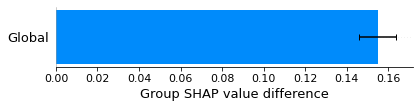

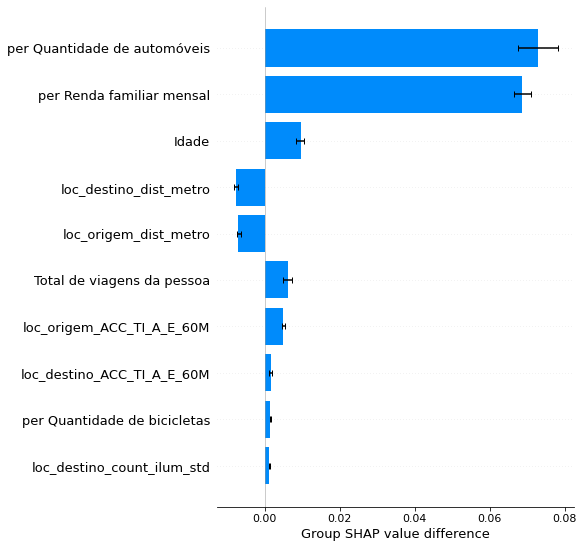

Ônibus
Valor Esperado: 0.16


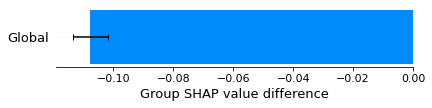

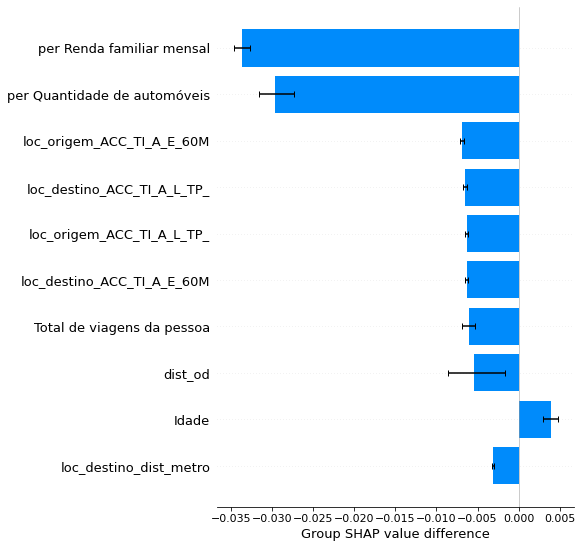

Uber
Valor Esperado: 0.03


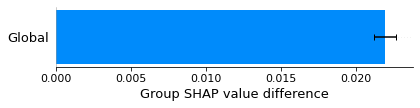

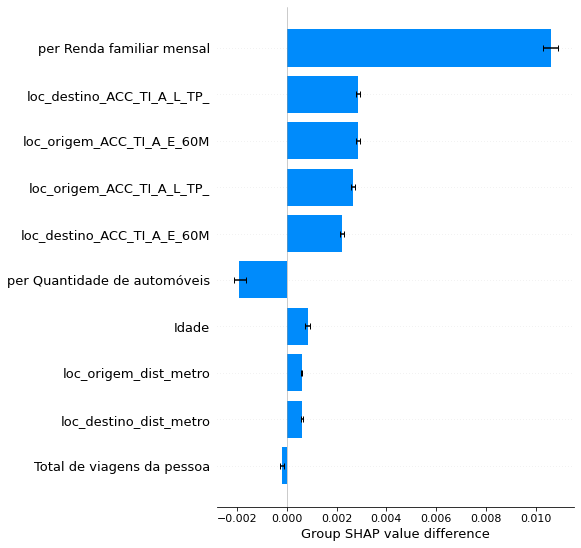

Bike
Valor Esperado: 0.01


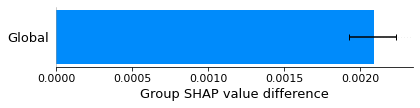

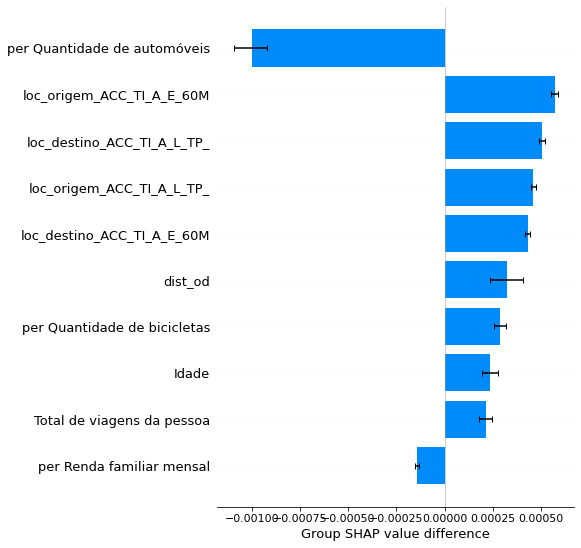

Metro/trem
Valor Esperado: 0.12


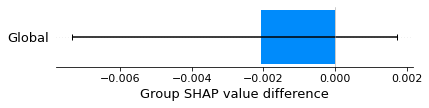

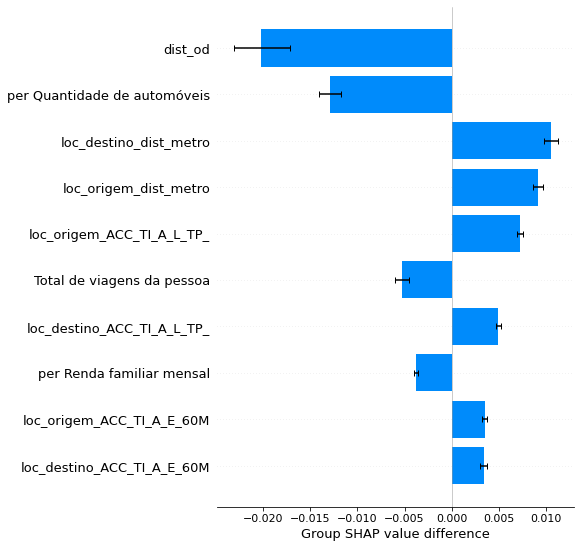

A pé
Valor Esperado: 0.34


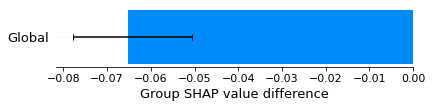

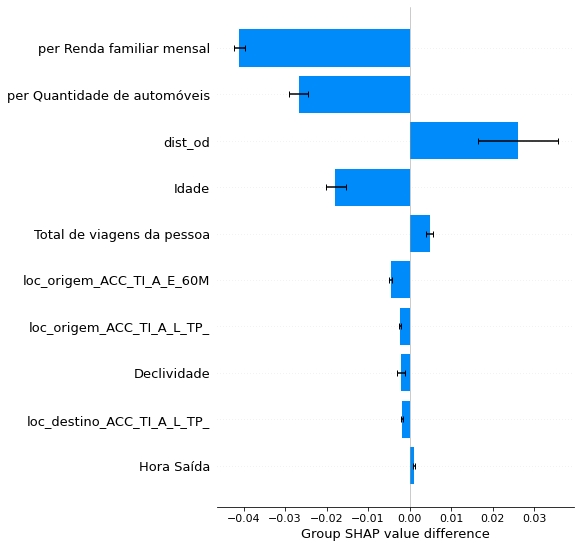

In [124]:
perif = ["Brasilândia", "Grajaú"]
centro = ["Moema", "Bela Vista"]

relevancia(perif, centro, [1,2,3,4,6,0], map_ref)

Valor da Feature para cada grupo >> Comportamento do Modelo para este modo de Transporte

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

FixedFormatter should only be used together with FixedLocator


Carro
Valor Esperado: 0.32


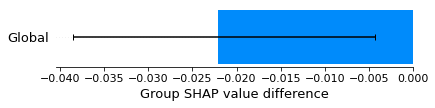

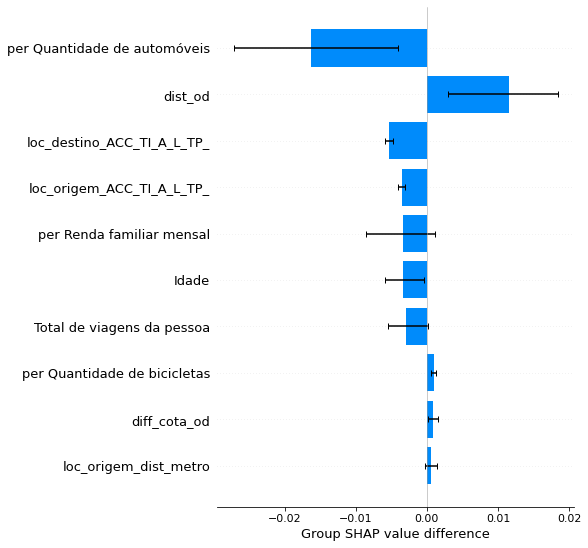

Ônibus
Valor Esperado: 0.16


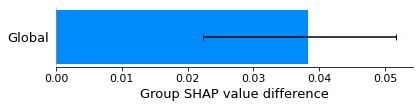

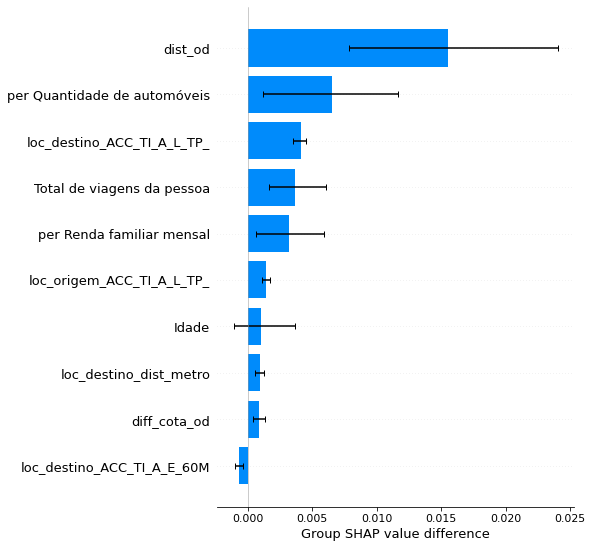

Uber
Valor Esperado: 0.03


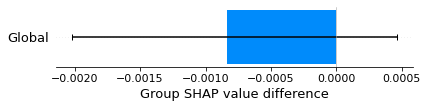

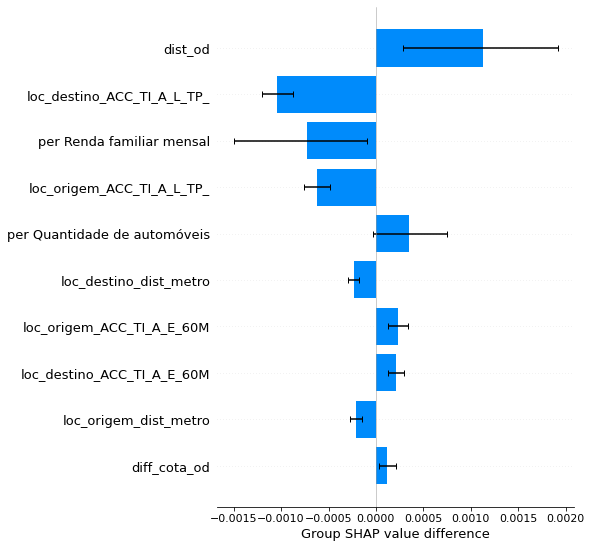

Bike
Valor Esperado: 0.01


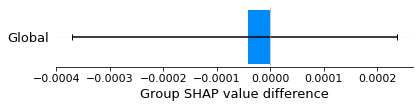

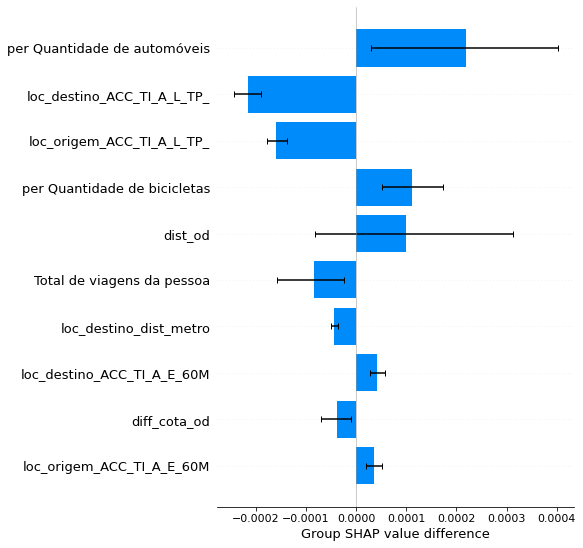

Metro/trem
Valor Esperado: 0.12


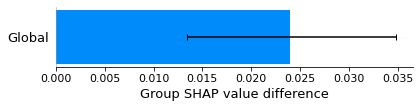

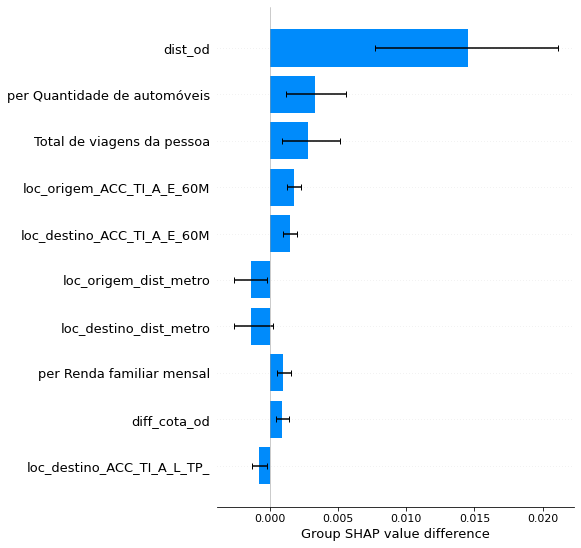

In [76]:
perif = ["Carrão"]
centro = ["Pirituba"]

relevancia(perif, centro, [1,2,3,4,6], map_ref)

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523



Carro
Valor Esperado: 0.33


FixedFormatter should only be used together with FixedLocator


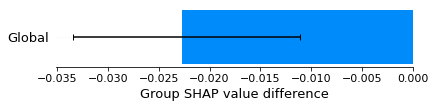

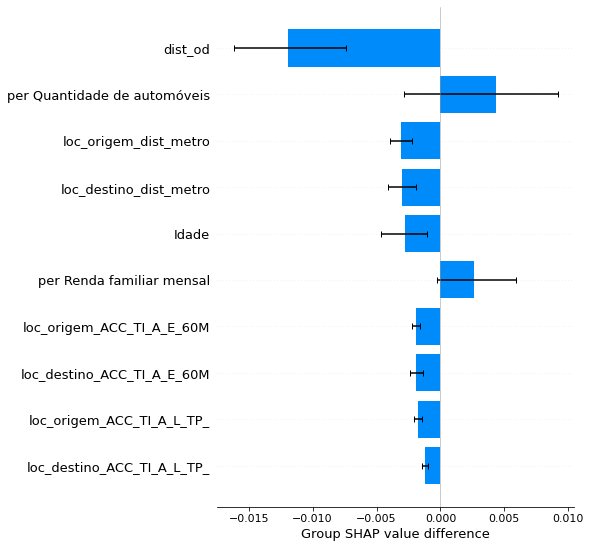

Uber
Valor Esperado: 0.03


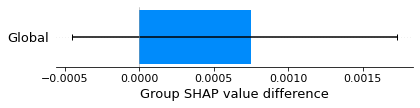

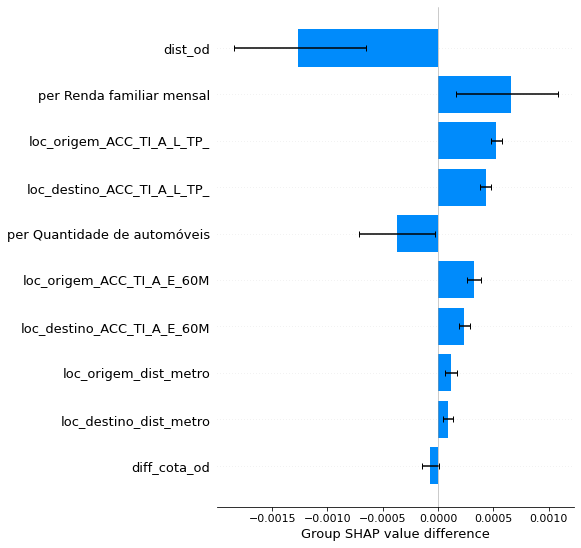

Bike
Valor Esperado: 0.01


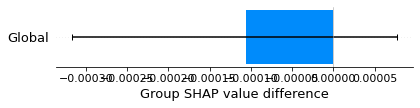

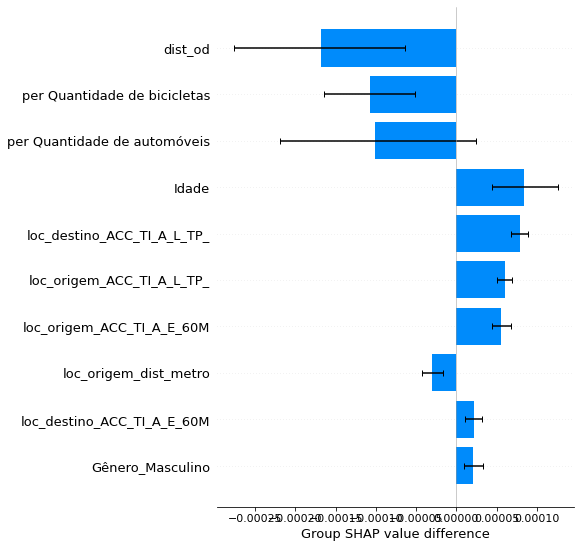

Metro/trem
Valor Esperado: 0.12


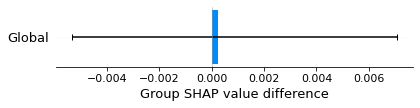

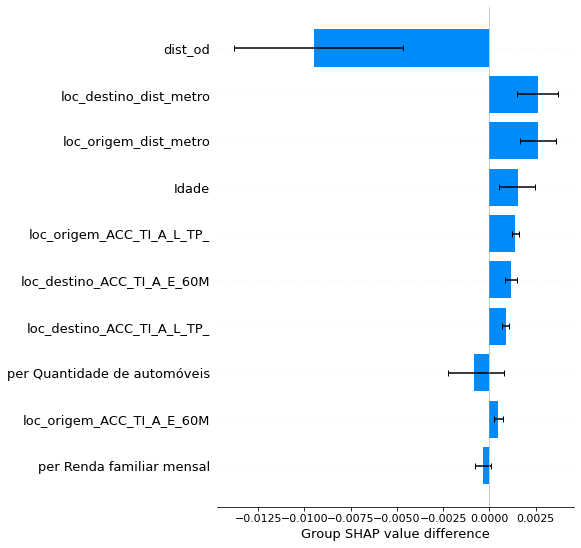

In [83]:
perif = ["Saúde"]
centro = ["Vila Mariana"]

relevancia(perif, centro, [1,3,4,6], map_ref)